In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys
sys.setrecursionlimit(10000)

print('IMPORT OK!!!!!!')
# Загрузка данных
bulls = pd.read_csv('/kaggle/input/cow-bull-breeding/data/bulls.csv')
cows = pd.read_csv('/kaggle/input/cow-bull-breeding/data/cows.csv')
pedigree = pd.read_csv('/kaggle/input/cow-bull-breeding/data/pedigree.csv')

# создаём словари
cow_ebv = dict(zip(cows['id'], cows['ebv']))
bull_ebv = dict(zip(bulls['id'], bulls['ebv']))

IMPORT OK!!!!!!


# Теперь вычисляем генетическую ценность (то самое EBV) для животных с неизвестными данными, используя родословную: создаётся общий словарь значений, где недостающие EBV заполняются рекурсивно через родителей — для быков учитывается точность данных (на основе количества потомков), для других животных используется среднее значение родителей (или 60% при одном известном родителе), а при полном отсутствии данных устанавливается ноль; после расчётов все таблицы обновляются заполненными значениями для последующих операций.

In [2]:
# 2. Заполнение пропусков в EBV с использованием родословной (иначе потом не получилось высчитать средний EBV и разброс) -----------------
#  словарь EBV всех животных
all_ebv = {}
parents = {}
all_animals = set(bulls['id']).union(cows['id']).union(pedigree['id'])


for animal_id in all_animals:
    if animal_id in cow_ebv:
        all_ebv[animal_id] = cow_ebv[animal_id]
    elif animal_id in bull_ebv:
        all_ebv[animal_id] = bull_ebv[animal_id]
    else:
        all_ebv[animal_id] = np.nan  # Помечаем неизвестные значения

# функция для вычисления EBV на основе родителей
descendants_count = dict(zip(bulls['id'], bulls['descendants_count'].fillna(0)))

def calculate_ebv(animal_id, depth=0, max_depth=10):
    if depth > max_depth:
        return 0  #защита от бесконечной рекурсии
    
    if animal_id in bull_ebv and not pd.isna(bull_ebv[animal_id]):
        return bull_ebv[animal_id] 

        
    father = parents.get(animal_id, {}).get('father')
    mother = parents.get(animal_id, {}).get('mother')
    
    father_ebv = calculate_ebv(father, depth+1, max_depth) if father else 0
    mother_ebv = calculate_ebv(mother, depth+1, max_depth) if mother else 0
    
    # вычисляем EBV по родителям
    if father and mother:
        return (father_ebv + mother_ebv) / 2
    elif father or mother:
        return (father_ebv + mother_ebv) * 0.6  # учитываем факт отсутсвия одного из родителей *штрафом* инбридинга
    else:
        return 0  # Базовое значение
# заполняем EBV для всех животных
for animal_id in all_animals:
    if animal_id in all_ebv and np.isnan(all_ebv[animal_id]):
        all_ebv[animal_id] = calculate_ebv(animal_id)

cows['ebv'] = cows['id'].map(all_ebv).fillna(0)
bulls['ebv'] = bulls['id'].map(all_ebv).fillna(0)

# пересоздание словарей EBV
cow_ebv = dict(zip(cows['id'], cows['ebv']))
bull_ebv = dict(zip(bulls['id'], bulls['ebv']))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


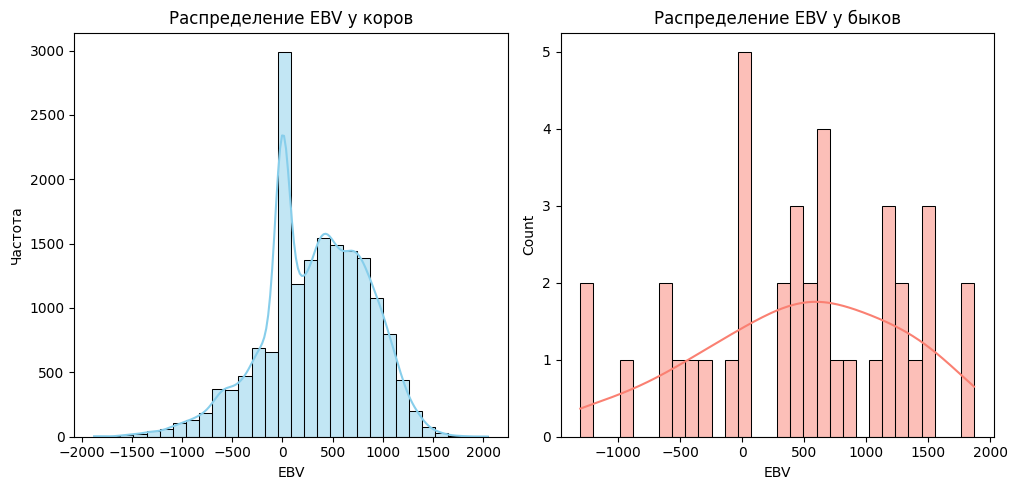

In [3]:
# Визуализация распределения EBV
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(cows['ebv'], bins=30, kde=True, color='skyblue')
plt.title('Распределение EBV у коров')
plt.xlabel('EBV')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
sns.histplot(bulls['ebv'], bins=30, kde=True, color='salmon')
plt.title('Распределение EBV у быков')
plt.xlabel('EBV')

plt.tight_layout()
plt.show()

# Вычисляем генетическую близость между животными для предотвращения инбридинга (кровосмешения) -- (1) словарь родителей для всех животных (с обработкой отсутствующих данных через None), затем используем рекурсивную функцию с мемоизацией (memo_kinship), которая рассчитывает коэффициент родства по стандартной формуле — 0.5 для животных без известных родителей и 0.5*(1 + kinship родителей) для особей с полной родословной; финальная проверка check_kinship отфильтровывает пары с родством >5%, сохраняя биологическое разнообразие.

In [4]:
# 3. расчёт коэффициентов родства ----------------------------------
parents = {}
all_animals = set(bulls['id']).union(cows['id']).union(pedigree['id'])

# словарь родителей
parent_dict = pedigree.set_index('id')[['father_id', 'mother_id']].to_dict('index')
parents = {aid: {'father': None, 'mother': None} for aid in all_animals}
for aid, pdata in parent_dict.items():
    if aid in parents:
        parents[aid] = {
            'father': pdata['father_id'] if pdata['father_id'] in all_animals else None,
            'mother': pdata['mother_id'] if pdata['mother_id'] in all_animals else None
        }

# мемоизация родства
memo_kinship = {}

def calc_kinship(a, b):
    if a not in parents or b not in parents:
        return 0.0
    
    # сортируем для единообразия ключа
    if a > b:
        a, b = b, a
        
    key = (a, b)
    if key in memo_kinship:
        return memo_kinship[key]
    
    if a == b:
        fa, mo = parents[a]['father'], parents[a]['mother']
        if fa is None or mo is None:
            k = 0.5
        else:
            k = 0.5 * (1 + calc_kinship(fa, mo))
    else:
        fb, mb = parents[b]['father'], parents[b]['mother']
        k = 0
        if fb:
            k += calc_kinship(a, fb)
        if mb:
            k += calc_kinship(a, mb)
        k *= .5
    
    memo_kinship[key] = k
    return k

# векторизированный расчет родства для всех пар
def check_kinship(cow_bull_pair):
    cow, bull = cow_bull_pair
    return calc_kinship(cow, bull) <= 0.05

# И под конец формируем пары "корова-бык" в два этапа: сначала параллельно проверяются все возможные комбинации на допустимое родство (≤5%) с расчётом EBV потомства, затем жадный алгоритм назначает быков коровам — сортирует пары по убыванию EBV, последовательно выбирая оптимальные варианты с контролем лимита использования быков (макс. 10% стада), а для оставшихся коров добавляет любых доступных быков, гарантируя 100% покрытие и максимизацию генетического потенциала.

In [5]:
# 4.  формирование допустимых пар --------------------------------
def generate_pairs():
    cow_ids = cows['id'].tolist()
    bull_ids = bulls['id'].tolist()
    pairs = []
    
    # создаем все возможные пары
    all_pairs = [(cow, bull) for cow in cow_ids for bull in bull_ids]
    
    # проверка родства
    print("Проверка родства...")
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(tqdm(executor.map(check_kinship, all_pairs), total=len(all_pairs)))
    
    # формируем допустимые пары с EBV
    for (cow, bull), is_valid in zip(all_pairs, results):
        if is_valid:
            ebv_score = (cow_ebv[cow] + bull_ebv[bull]) / 2.0
            pairs.append((cow, bull, ebv_score))
    
    return pairs

allowed_pairs = generate_pairs()
print(f"Сформировано {len(allowed_pairs)} допустимых пар")

# 5. жадная оптимизация назначений -------------------------------------------
def greedy_assignment(pairs, max_bull_uses):
    # сортировка пары по EBV (по убыыванию)
    sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)
    
    assignments = {}
    bull_counts = {bull: 0 for bull in bulls['id']}
    assigned_cows = set()
    total_ebv = 0
    
    # жадное назначение
    for cow, bull, ebv in sorted_pairs:
        if cow in assigned_cows:
            continue
        if bull_counts[bull] < max_bull_uses:
            assignments[cow] = bull
            assigned_cows.add(cow)
            bull_counts[bull] += 1
            total_ebv += ebv
    
    # обработка непокрытых коров (если есть)
    unassigned_cows = set(cows['id']) - assigned_cows
    print(f"Непокрыто коров: {len(unassigned_cows)}")
    
    for cow in unassigned_cows:
        # ищем любого доступного быка
        for bull in bulls['id']:
            if bull_counts[bull] < max_bull_uses:
                assignments[cow] = bull
                bull_counts[bull] += 1
                break
    
    return assignments, total_ebv

print("Жадная оптимизация назначений...")
max_bull_uses = max(1, (len(cows) + 9) // 10)  # максимальная нагрузка 10% коров на быка
assignments, total_ebv = greedy_assignment(allowed_pairs, max_bull_uses)

Проверка родства...


100%|██████████| 669903/669903 [00:01<00:00, 470812.55it/s]


Сформировано 658364 допустимых пар
Жадная оптимизация назначений...
Непокрыто коров: 0


In [6]:
# 6. Экспорт результатов -----------------------------------------------------
# делаем датафрейм
assignments_list = [{'cow_id': cow, 'bull_id': bull} for cow, bull in assignments.items()]
assignments_df = pd.DataFrame(assignments_list)
assignments_df.to_csv('cow_bull_assignments.csv', index=False)

# Расчет метрик
ebv_values = []
for cow, bull in assignments.items():
    ebv = (cow_ebv[cow] + bull_ebv[bull]) / 2.0
    ebv_values.append(ebv)

avg_ebv = np.mean(ebv_values) if ebv_values else 0
ebv_variance = np.var(ebv_values) if ebv_values else 0

print(f'Средний EBV потомства: {avg_ebv:.4f}')
print(f'Дисперсия EBV: {ebv_variance:.4f}')
print(f'Назначено коров: {len(assignments)} из {len(cows)}')

# Проверка ограничений
bull_usage = assignments_df['bull_id'].value_counts()
print(f"Макс. использование быков: {bull_usage.max()} коров (лимит: {max_bull_uses})")
print("Готово! Результаты сохранены в cow_bull_assignments.csv")


Средний EBV потомства: 889.6915
Дисперсия EBV: 133320.4238
Назначено коров: 17177 из 17177
Макс. использование быков: 1718 коров (лимит: 1718)
Готово! Результаты сохранены в cow_bull_assignments.csv
